For Collab

In [ ]:
!git clone https://github.com/GerardTho/Deep_image_prior_inpainting.git

In [ ]:
cd Deep_image_prior_inpainting

In [1]:
import torch
import numpy as np
from PIL import Image

import utils
from model.EncoderDecoder import EncoderDecoder
from model.EncoderDecoderSkipConnections import EncoderDecoderSkipConnections
from model.EncoderDecoderResidualConnections import EncoderDecoderResidualConnections
from model.EdgeModeInpainting import InpaintGenerator, EdgeGenerator

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cpu


In [6]:
input_depth = 2
LR = 0.01
num_iter = 5000
show_every = 100
figsize = 5
reg_noise_std = 0.03
OPTIMIZER = 'adam'
model_selection = "EncoderDecoderSkipConnections"

In [7]:
img_path  = 'data/stairs.jpg'
mask_path = 'data/stairs_mask.jpg'
img_pil, img_np = utils.get_image(img_path)
img_mask_pil, img_mask_np = utils.get_image(mask_path)
img_mask_pil = utils.crop_image(img_mask_pil, d=64)
img_pil      = utils.crop_image(img_pil, d=64)
img_np      = utils.pil_to_np(img_pil)
img_mask_np = utils.pil_to_np(img_mask_pil)

In [8]:
if model_selection == "EncoderDecoder":
    model = EncoderDecoder(num_input_channels=input_depth, num_output_channels=img_np.shape[0],
                        n_upsampler=[128, 128, 128, 64, 32, 16],
                        n_downsampler=[16, 32, 64, 128, 128, 128],
                        k_upsampler=[3, 3, 3, 3, 3, 3],
                        k_downsampler=[5, 5, 5, 5, 5, 5],).to(device)
elif model_selection == "EncoderDecoderSkipConnections":
    model = EncoderDecoderSkipConnections(num_input_channels=input_depth, num_output_channels=img_np.shape[0],
                        n_upsampler=[128, 128, 128, 64, 32, 16],
                        n_downsampler=[16, 32, 64, 128, 128, 128],
                        n_skip=[0,0,0,0,0,0],
                        k_upsampler=[3, 3, 3, 3, 3, 3],
                        k_downsampler=[5, 5, 5, 5, 5, 5],
                        k_skip=[1,1,1,1,1,1],).to(device)
elif model_selection == "EncoderDecoderResidualConnections":
    model = EncoderDecoderResidualConnections(num_input_channels=input_depth, num_output_channels=img_np.shape[0],
                        n_upsampler=[128, 128, 128, 64, 32, 16],
                        n_downsampler=[16, 32, 64, 128, 128, 128],
                        k_upsampler=[3, 3, 3, 3, 3, 3],
                        k_downsampler=[5, 5, 5, 5, 5, 5],).to(device)

c:\Users\wande\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [9]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in model.parameters())
print ('Number of params: %d' % s)

img_var = torch.from_numpy(img_np).reshape(-1, img_np.shape[0], img_np.shape[1], img_np.shape[2]).to(device)
mask_var = torch.from_numpy(img_mask_np).reshape(-1, img_mask_np.shape[0], img_mask_np.shape[1], img_mask_np.shape[2]).to(device)

# Loss
mse = torch.nn.MSELoss()

net_input = utils.generate_noise_mesh_grid(input_depth, img_np.shape[1:]).reshape(1, -1, img_np.shape[1], img_np.shape[2] ).to(torch.float32).to(device)

Number of params: 3155363


In [ ]:
def optimize(parameters, LR, num_iter):
  optimizer = torch.optim.Adam(parameters, lr=LR)
  for j in range(num_iter):
    optimizer.zero_grad()

    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = model(net_input)
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()

    optimizer.step()

    print ('Iteration %05d    Loss %f' % (j, total_loss.item()), '\r', end='')
    if j % show_every == 0:
        out_np = out.detach().cpu().numpy()[0]
        utils.plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
  # Return last iteration
  return out_np
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = [x for x in model.parameters()]
out_np = optimize(p, LR, num_iter)

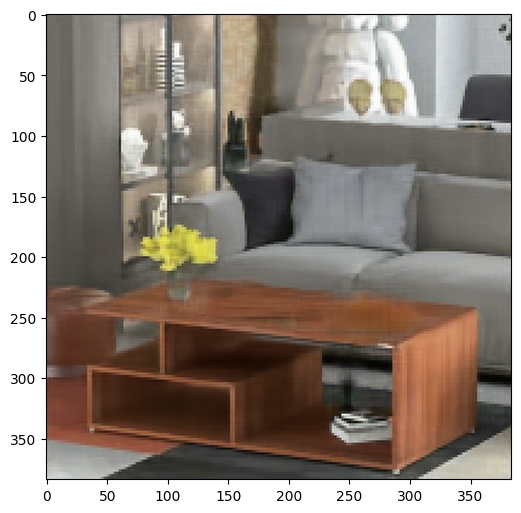

In [8]:
out_np = model(net_input).detach().cpu().numpy()[0]
utils.plot_image_grid([out_np], factor=5);

In [9]:
img_np

array([[[0.42352942, 0.43137255, 0.43137255, ..., 0.70980394,
         0.73333335, 0.7254902 ],
        [0.41960785, 0.43137255, 0.43137255, ..., 0.6784314 ,
         0.6666667 , 0.65882355],
        [0.42745098, 0.43137255, 0.43529412, ..., 0.7137255 ,
         0.73333335, 0.6784314 ],
        ...,
        [0.8235294 , 0.81960785, 0.8       , ..., 0.7764706 ,
         0.77254903, 0.79607844],
        [0.8666667 , 0.90588236, 0.8980392 , ..., 0.78039217,
         0.7882353 , 0.79607844],
        [0.7882353 , 0.78431374, 0.8117647 , ..., 0.79607844,
         0.7647059 , 0.77254903]],

       [[0.4117647 , 0.41960785, 0.41960785, ..., 0.72156864,
         0.7529412 , 0.74509805],
        [0.40784314, 0.41960785, 0.41960785, ..., 0.69803923,
         0.6862745 , 0.69411767],
        [0.41568628, 0.41960785, 0.42352942, ..., 0.7372549 ,
         0.76862746, 0.7176471 ],
        ...,
        [0.8509804 , 0.84705883, 0.83137256, ..., 0.7529412 ,
         0.7607843 , 0.78431374],
        [0.8

In [41]:
utils.PSNR(img_np, out_np)

75.3817857741644

In [23]:
img_path  = 'data/floor.jpg'
mask_path = 'data/floor_mask.jpg'
img_pil, img_np = utils.get_image(img_path)
img_pil.thumbnail((256, 256), Image.Resampling.LANCZOS)
img_mask_pil, img_mask_np = utils.get_image(mask_path)
img_mask_pil.thumbnail((256, 256), Image.Resampling.LANCZOS)
img_mask_pil = utils.crop_image(img_mask_pil)
img_pil      = utils.crop_image(img_pil)
img_np      = utils.pil_to_np(img_pil)
img_mask_np = utils.pil_to_np(img_mask_pil)
img_masked = img_np*img_mask_np + (1-img_mask_np)

In [24]:
edge_model = EdgeGenerator(init_weights=False)
edge_model.load_state_dict(torch.load('pretrained_GAN/EdgeModel_gen.pth', map_location=device)["generator"])
inpaint_model = InpaintGenerator(init_weights=False)
inpaint_model.load_state_dict(torch.load('pretrained_GAN/InpaintingModel_gen.pth', map_location=device)["generator"])

<All keys matched successfully>

In [25]:
img_edge = edge_model(torch.from_numpy(1-img_np))

In [26]:
img_inpainted = inpaint_model(torch.cat((torch.from_numpy(img_masked), img_edge), dim=0)).detach().cpu().numpy()

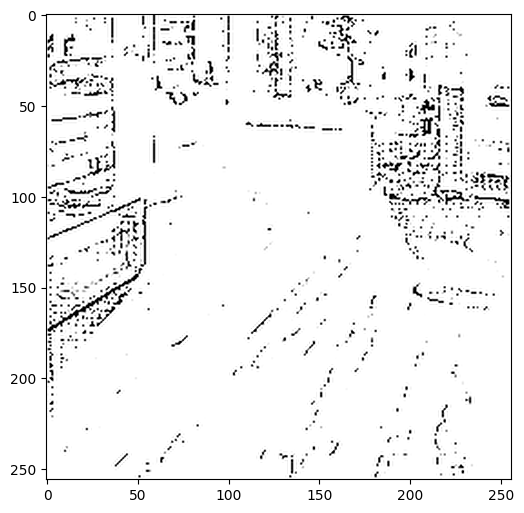

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)

In [27]:
utils.plot_image_grid([np.clip(1-img_edge.detach().cpu().numpy(), 0, 1)], factor=figsize, nrow=1)

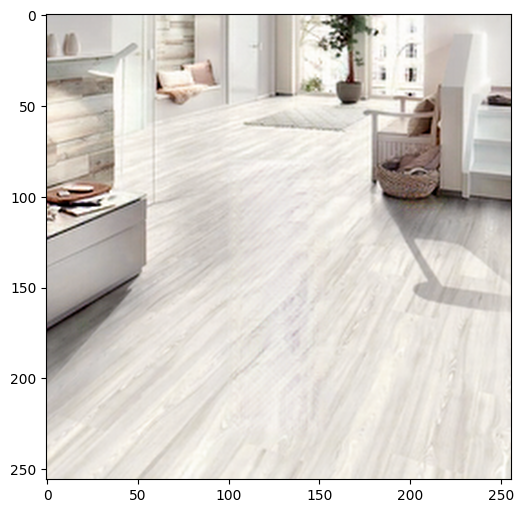

array([[[0.7657666 , 0.77512914, 0.77262366, ..., 0.8482114 ,
         0.85961384, 0.8583411 ],
        [0.76893175, 0.77328354, 0.7714896 , ..., 0.85284936,
         0.8531804 , 0.8495902 ],
        [0.77338916, 0.77948236, 0.77495515, ..., 0.8605653 ,
         0.8526069 , 0.8496977 ],
        ...,
        [0.92805004, 0.9024495 , 0.90624887, ..., 0.9189921 ,
         0.88287705, 0.8766285 ],
        [0.89937687, 0.91322994, 0.92906016, ..., 0.9155055 ,
         0.8856646 , 0.87545663],
        [0.9007953 , 0.91900885, 0.91723365, ..., 0.89685524,
         0.8754854 , 0.8591842 ]],

       [[0.75524116, 0.7629852 , 0.7570622 , ..., 0.83843267,
         0.85096335, 0.8511938 ],
        [0.7542579 , 0.7631653 , 0.7573214 , ..., 0.84257674,
         0.84463364, 0.8450482 ],
        [0.7664863 , 0.7702316 , 0.76657534, ..., 0.85177135,
         0.84646356, 0.8457941 ],
        ...,
        [0.91725904, 0.88132364, 0.8825566 , ..., 0.91400206,
         0.8757274 , 0.86688304],
        [0.8

In [28]:
utils.plot_image_grid([np.clip(img_inpainted, 0, 1)], factor=figsize, nrow=1)

In [29]:
utils.PSNR(img_np ,img_inpainted)

27.97492934905602